In [8]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing

%matplotlib inline

label_encoder = preprocessing.LabelEncoder()

In [38]:
data1 = pd.read_csv("data/phishing_websites.csv").astype('category')
data2 = pd.read_csv("data/online_shoppers_intention.csv")
data1.drop(['id'], axis=1, inplace=True)


### phishing data preprocessing

In [39]:
col_to_one_hot = []
col_to_one_hot_index = []
for i, col in enumerate(data1):
    print(col, data1[col].unique())
    if data1[col].unique().size > 2:
        col_to_one_hot.append(col)
        col_to_one_hot_index.append(i)
df = data1[col_to_one_hot[0]]
df2 = pd.get_dummies(df)
print(df2)
# for col in data1:
#     data1.loc[data1[col] < 0, col] = 2
# 
# one_hot_encoder = preprocessing.OneHotEncoder(categorical_features=col_to_one_hot_index)
# data11 = one_hot_encoder.fit_transform(data1).toarray()
# 
# print(data11.shape)
# # df = one_hot_encoder.fit_transform(data1)
# # df.toarray()
data1.head()
# df_phish = pd.read_csv("data/phishing_websites.csv").astype('category')
# col_1hot = ['URL_Length','having_Sub_Domain','SSLfinal_State','URL_of_Anchor','Links_in_tags','SFH','web_traffic','Links_pointing_to_page']
# df_1hot = df_phish[col_1hot]
# df_1hot = pd.get_dummies(df_1hot)
# df_others = df_phish.drop(col_1hot,axis=1)
# df_phish = pd.concat([df_1hot,df_others],axis=1)
# df_phish = df_phish.replace(-1,0).astype('category')
# column_order = list(df_phish)
# column_order.insert(0, column_order.pop(column_order.index('Result')))
# df_phish = df_phish.loc[:, column_order]  #move the target variable 'Result' to the front
# df_phish.describe(include='all')

having_IP_Address [-1, 1]
Categories (2, int64): [-1, 1]
URL_Length [1, 0, -1]
Categories (3, int64): [1, 0, -1]
Shortining_Service [1, -1]
Categories (2, int64): [1, -1]
having_At_Symbol [1, -1]
Categories (2, int64): [1, -1]
double_slash_redirecting [-1, 1]
Categories (2, int64): [-1, 1]
Prefix_Suffix [-1, 1]
Categories (2, int64): [-1, 1]
having_Sub_Domain [-1, 0, 1]
Categories (3, int64): [-1, 0, 1]
SSLfinal_State [-1, 1, 0]
Categories (3, int64): [-1, 1, 0]
Domain_registeration_length [-1, 1]
Categories (2, int64): [-1, 1]
Favicon [1, -1]
Categories (2, int64): [1, -1]
port [1, -1]
Categories (2, int64): [1, -1]
HTTPS_token [-1, 1]
Categories (2, int64): [-1, 1]
Request_URL [1, -1]
Categories (2, int64): [1, -1]
URL_of_Anchor [-1, 0, 1]
Categories (3, int64): [-1, 0, 1]
Links_in_tags [1, -1, 0]
Categories (3, int64): [1, -1, 0]
SFH [-1, 1, 0]
Categories (3, int64): [-1, 1, 0]
Submitting_to_email [-1, 1]
Categories (2, int64): [-1, 1]
Abnormal_URL [-1, 1]
Categories (2, int64): [-1

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1



### online shopper data preprocessing

In [15]:
columns_to_encode = ['Month', 'VisitorType','Weekend','Revenue']
label_encoder = preprocessing.LabelEncoder()
df = data2[columns_to_encode]
df = df.apply(label_encoder.fit_transform)
data2 = data2.drop(columns_to_encode, axis=1)
data2 = pd.concat([data2, df], axis=1)
data2.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Month,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,1,1,1,1,2,2,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,1,2,2,2,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,4,1,9,3,2,2,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,3,2,2,4,2,2,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,3,3,1,4,2,2,1,0


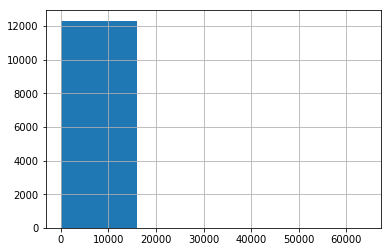

In [6]:
data2['ProductRelated_Duration'].hist(bins=4)